### Imports & Misc.

In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import config
import pandas as pd
import numpy as np
import joblib

from utils.constants import (
    MODEL_STANDARD_DIR, 
    DATA_DIR, 
    DATA_TEST_DEPARTING_DIR, 
    DATA_TEST_LANDING_DIR, 
    DATA_TEST_MANOEUVER_DIR, 
    DATA_TEST_NOISE_DIR, 
    DATA_TRAIN_DIR, 
    STATE_VECTOR_FEATURES, 
    K_LAG, 
    K_ORDER, 
    DATA_VALIDATION_DIR, 
    DIFF_DATA, 
    DIFF_FEATURES, 
    FEATURES, 
    WINDOW_SIZE_STANDARD_AUTOENCODER, 
    STANDARD_AUTOENCODER_ENCODING_DIMENSION, 
    
)
from utils.autoencoder import get_quantized_autoencoder_model, pruning_params, autoencoder_model_feature_pipeline
from utils.preprocessing import filter_outliers, diff_data, get_windows_data
from utils.plotting import plot_training_history
import matplotlib.pyplot as plt
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule, prune, pruning_callbacks
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import tsfresh as tf
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
print(os.getcwd())

/home/jovyan/adsb_pynqz2


In [4]:
if not os.path.exists(MODEL_STANDARD_DIR):
    os.makedirs(MODEL_STANDARD_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [4]:
!yes | unzip data.zip

Archive:  data.zip
replace data/test/manoeuver/CFG114.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/CFG114.csv  
replace data/test/manoeuver/VIR63.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/VIR63.csv  
replace data/test/manoeuver/BAW60T.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW60T.csv  
replace data/test/manoeuver/DLH444.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/DLH444.csv  
replace data/test/manoeuver/BAW175.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW175.csv  
replace data/test/manoeuver/BAW9L.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW9L.csv  
replace data/test/manoeuver/BAW9154.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW9154.csv  
replace data/test/departing/CFG114.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/departing/CFG1

In [5]:
df_sample = pd.read_csv(os.path.join(DATA_TRAIN_DIR, "BAW88MC.csv"))
df_sample_man = pd.read_csv(os.path.join(DATA_TEST_MANOEUVER_DIR, "BAW175.csv"))
df_sample_dep = pd.read_csv(os.path.join(DATA_TEST_DEPARTING_DIR, "BAW175.csv"))
df_sample_lan = pd.read_csv(os.path.join(DATA_TEST_LANDING_DIR, "BAW175.csv"))
df_sample_noi = pd.read_csv(os.path.join(DATA_TEST_NOISE_DIR, "BAW175.csv"))

In [6]:
diff_temp_df = filter_outliers(df_sample, cols=STATE_VECTOR_FEATURES)

In [7]:
diff_temp_man_df = filter_outliers(df_sample_man, cols=STATE_VECTOR_FEATURES)
diff_temp_dep_df = filter_outliers(df_sample_dep, cols=STATE_VECTOR_FEATURES)
diff_temp_lan_df = filter_outliers(df_sample_lan, cols=STATE_VECTOR_FEATURES)
diff_temp_noi_df = filter_outliers(df_sample_noi, cols=STATE_VECTOR_FEATURES)

In [8]:
diff_temp_df = diff_data(df_sample, cols=STATE_VECTOR_FEATURES, lag=K_LAG, order=K_ORDER)
diff_temp_man_df = diff_data(df_sample_man, cols=STATE_VECTOR_FEATURES, lag=K_LAG, order=K_ORDER)
diff_temp_dep_df = diff_data(df_sample_dep, cols=STATE_VECTOR_FEATURES, lag=K_LAG, order=K_ORDER)
diff_temp_lan_df = diff_data(df_sample_lan, cols=STATE_VECTOR_FEATURES, lag=K_LAG, order=K_ORDER)
diff_temp_noi_df = diff_data(df_sample_noi, cols=STATE_VECTOR_FEATURES, lag=K_LAG, order=K_ORDER)

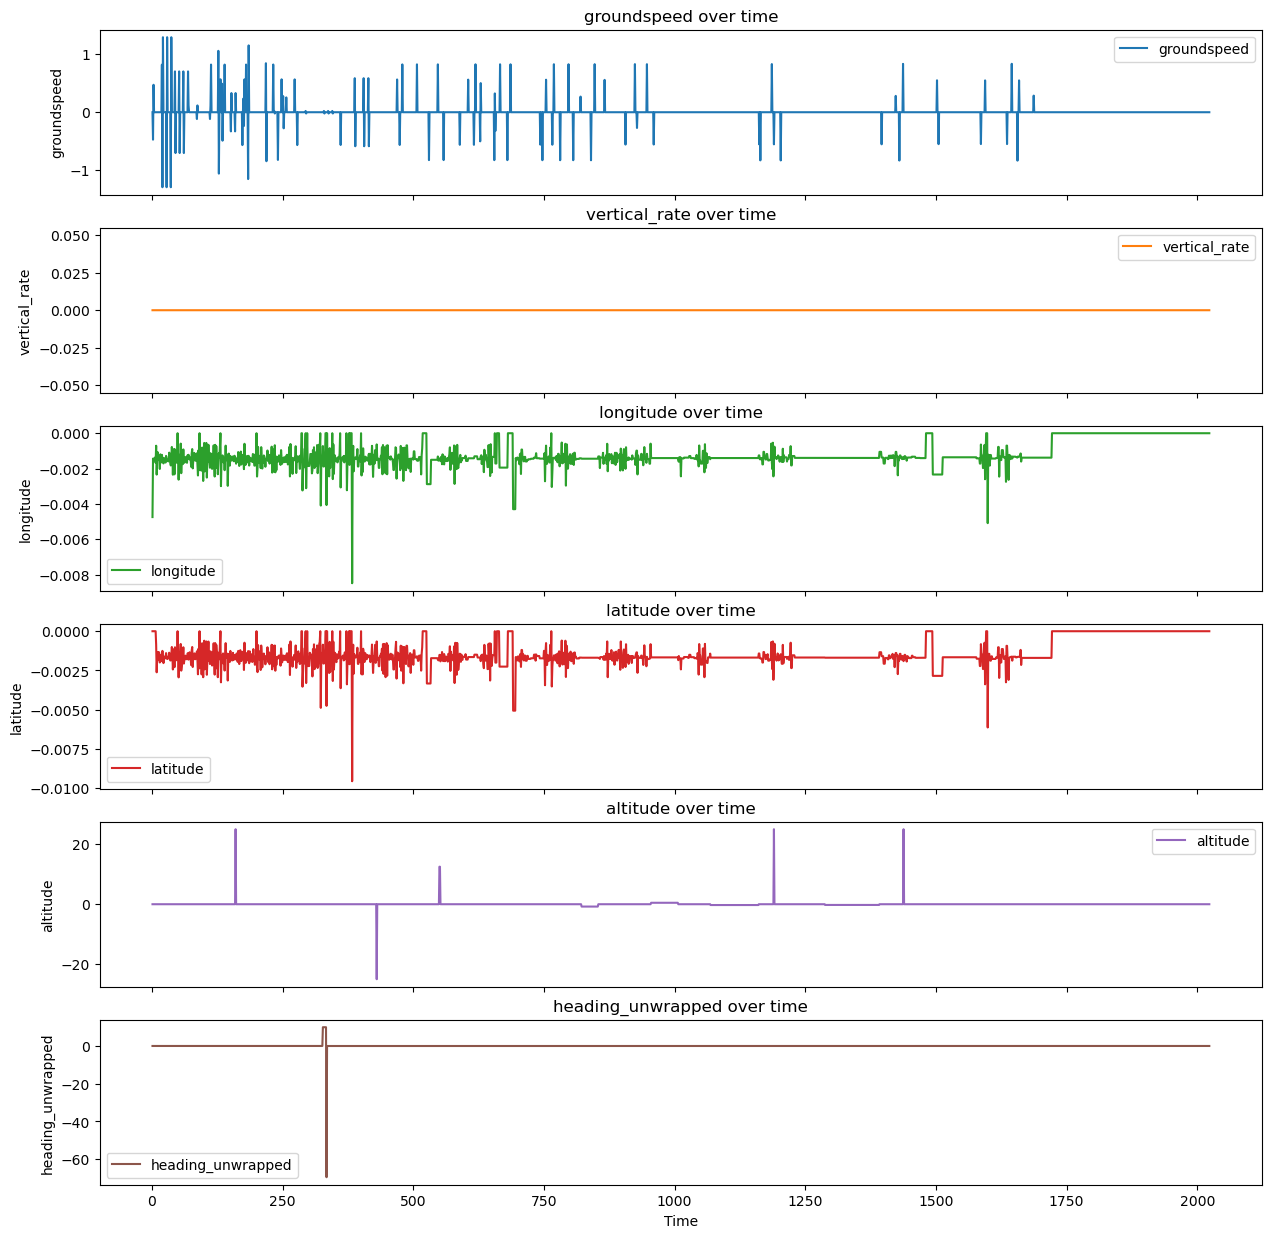

In [9]:
ax = diff_temp_df[STATE_VECTOR_FEATURES].plot(subplots=True, sharex=True, figsize=(15, 15))
for a, feature in zip(ax, STATE_VECTOR_FEATURES):
    a.set_title(f'{feature} over time')
    a.set_xlabel('Time')
    a.set_ylabel(feature)
plt.show()

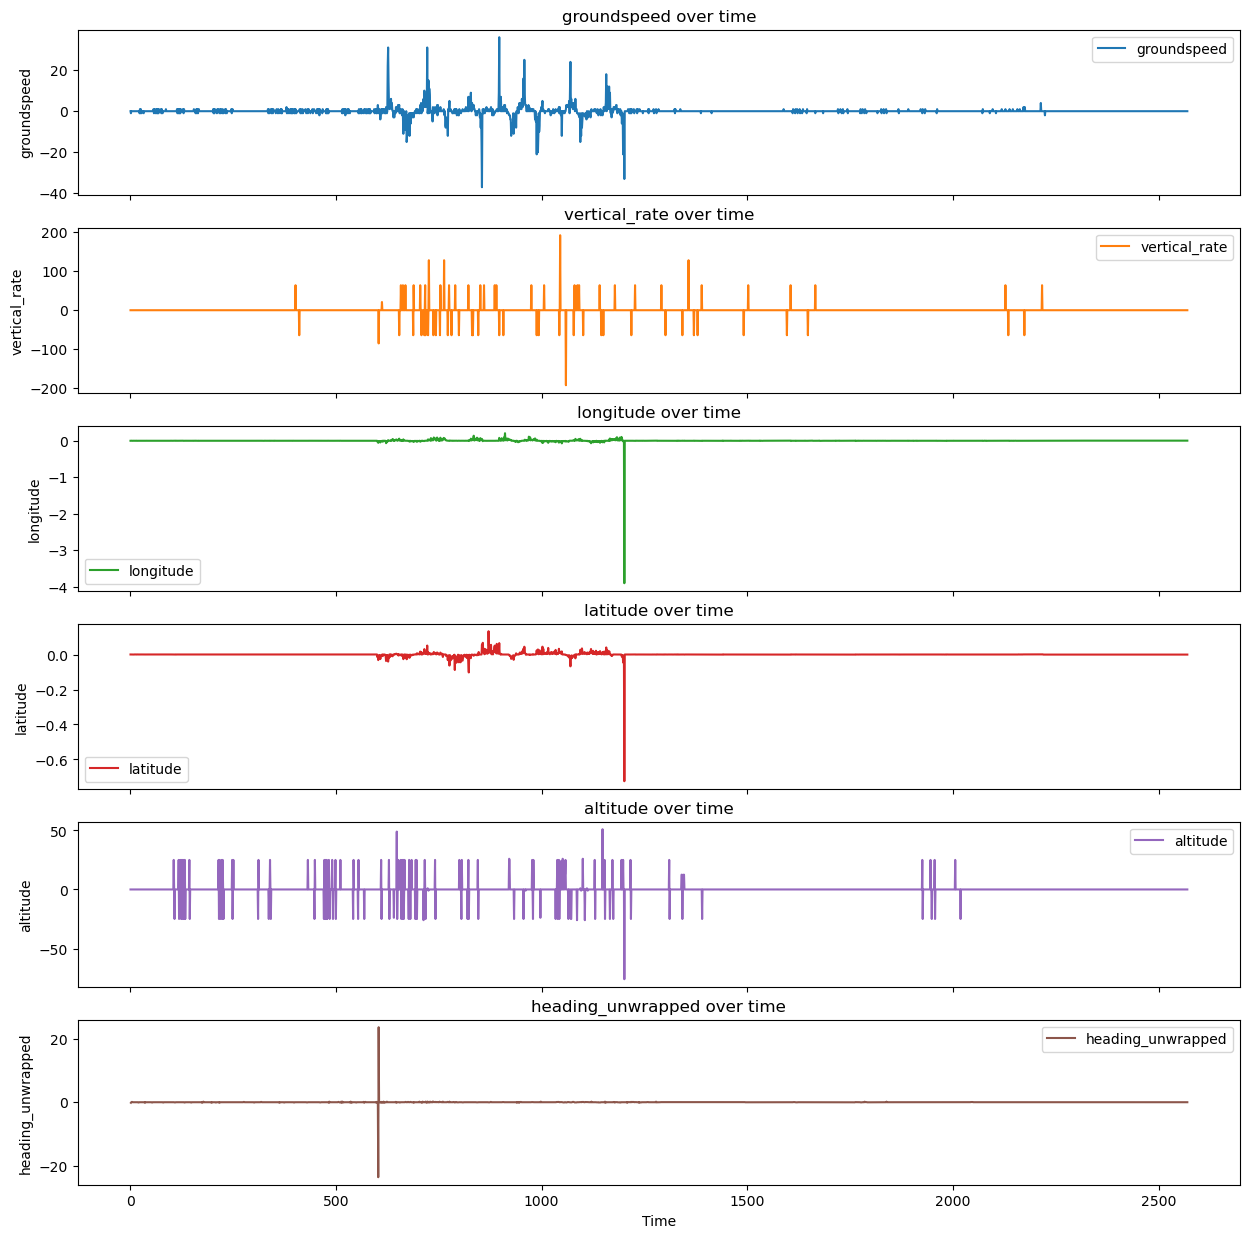

In [10]:
bx = diff_temp_man_df[STATE_VECTOR_FEATURES].plot(subplots=True, sharex=True, figsize=(15, 15))
for b, feature in zip(bx, STATE_VECTOR_FEATURES):
    b.set_title(f'{feature} over time')
    b.set_xlabel('Time')
    b.set_ylabel(feature)
plt.show()

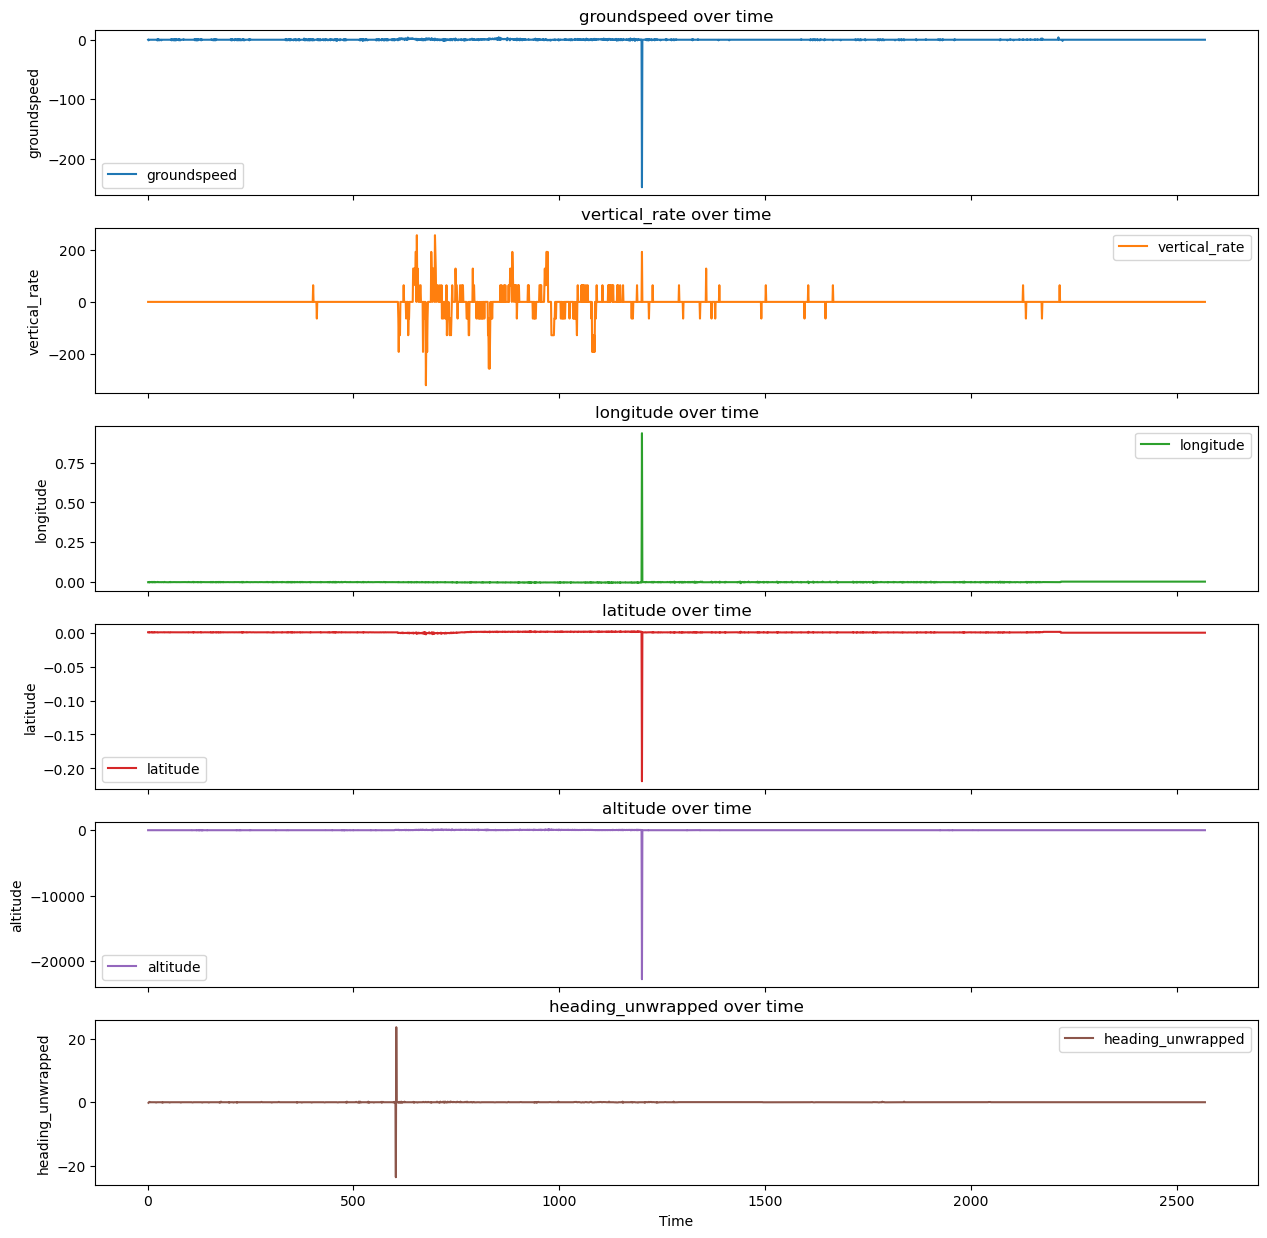

In [11]:
cx = diff_temp_dep_df[STATE_VECTOR_FEATURES].plot(subplots=True, sharex=True, figsize=(15,15))
for c, feature in zip(cx, STATE_VECTOR_FEATURES):
    c.set_title(f'{feature} over time')
    c.set_xlabel('Time')
    c.set_ylabel(feature)
plt.show()

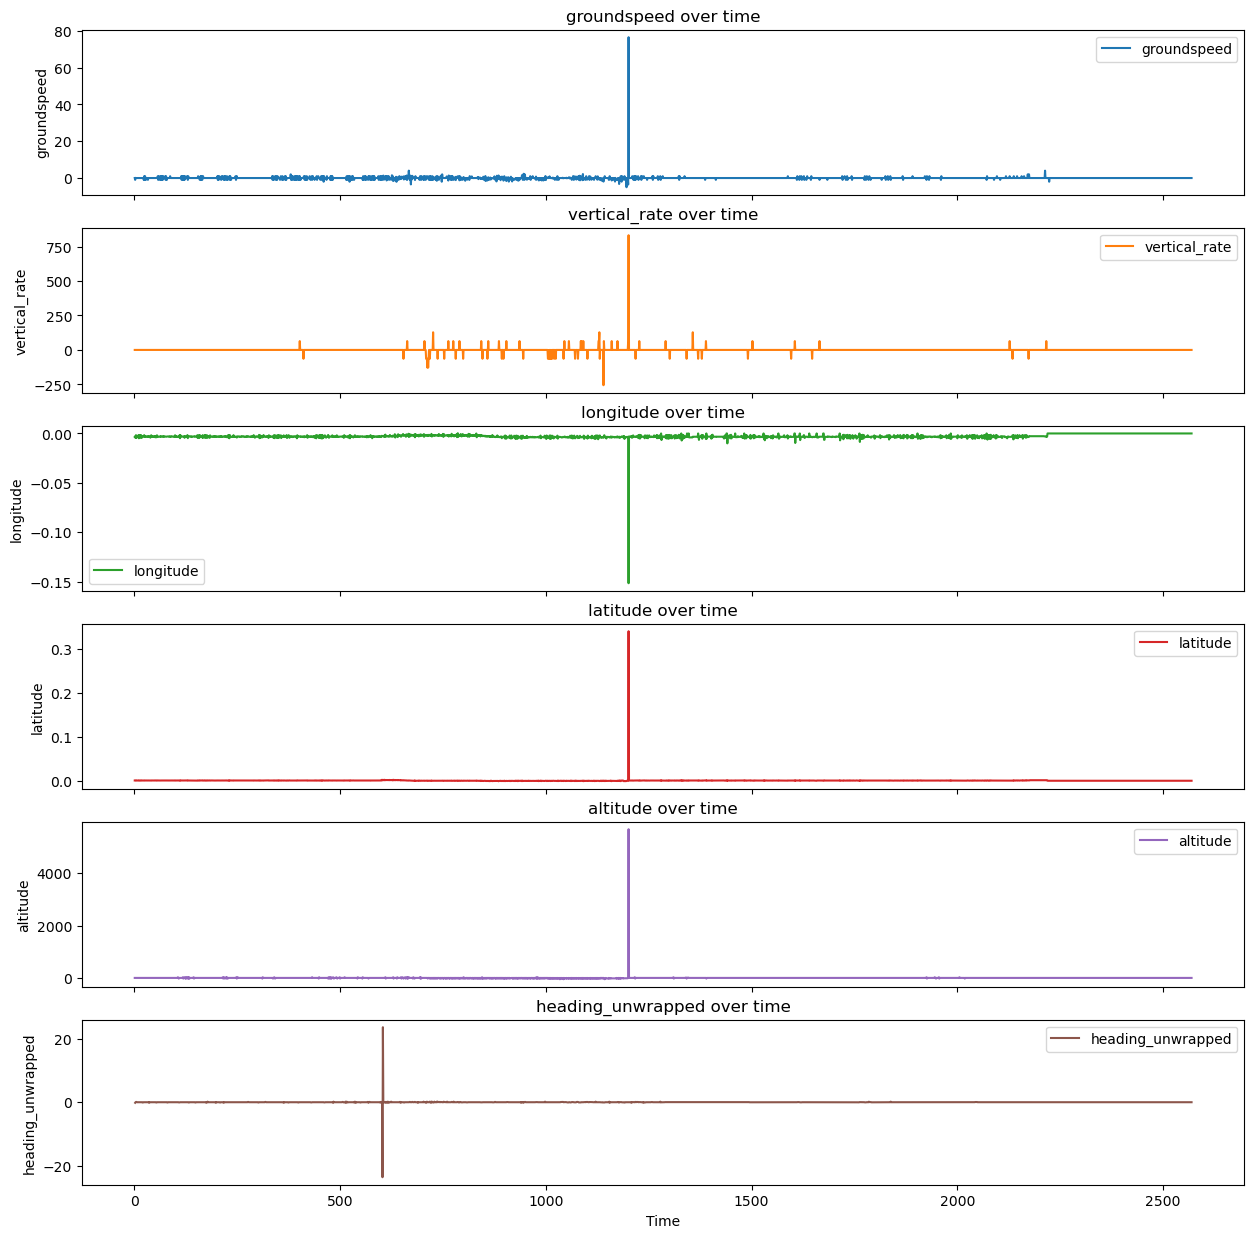

In [12]:
dx = diff_temp_lan_df[STATE_VECTOR_FEATURES].plot(subplots=True, sharex=True, figsize=(15,15))
for d, feature in zip(dx, STATE_VECTOR_FEATURES):
    d.set_title(f'{feature} over time')
    d.set_xlabel('Time')
    d.set_ylabel(feature)
plt.show()

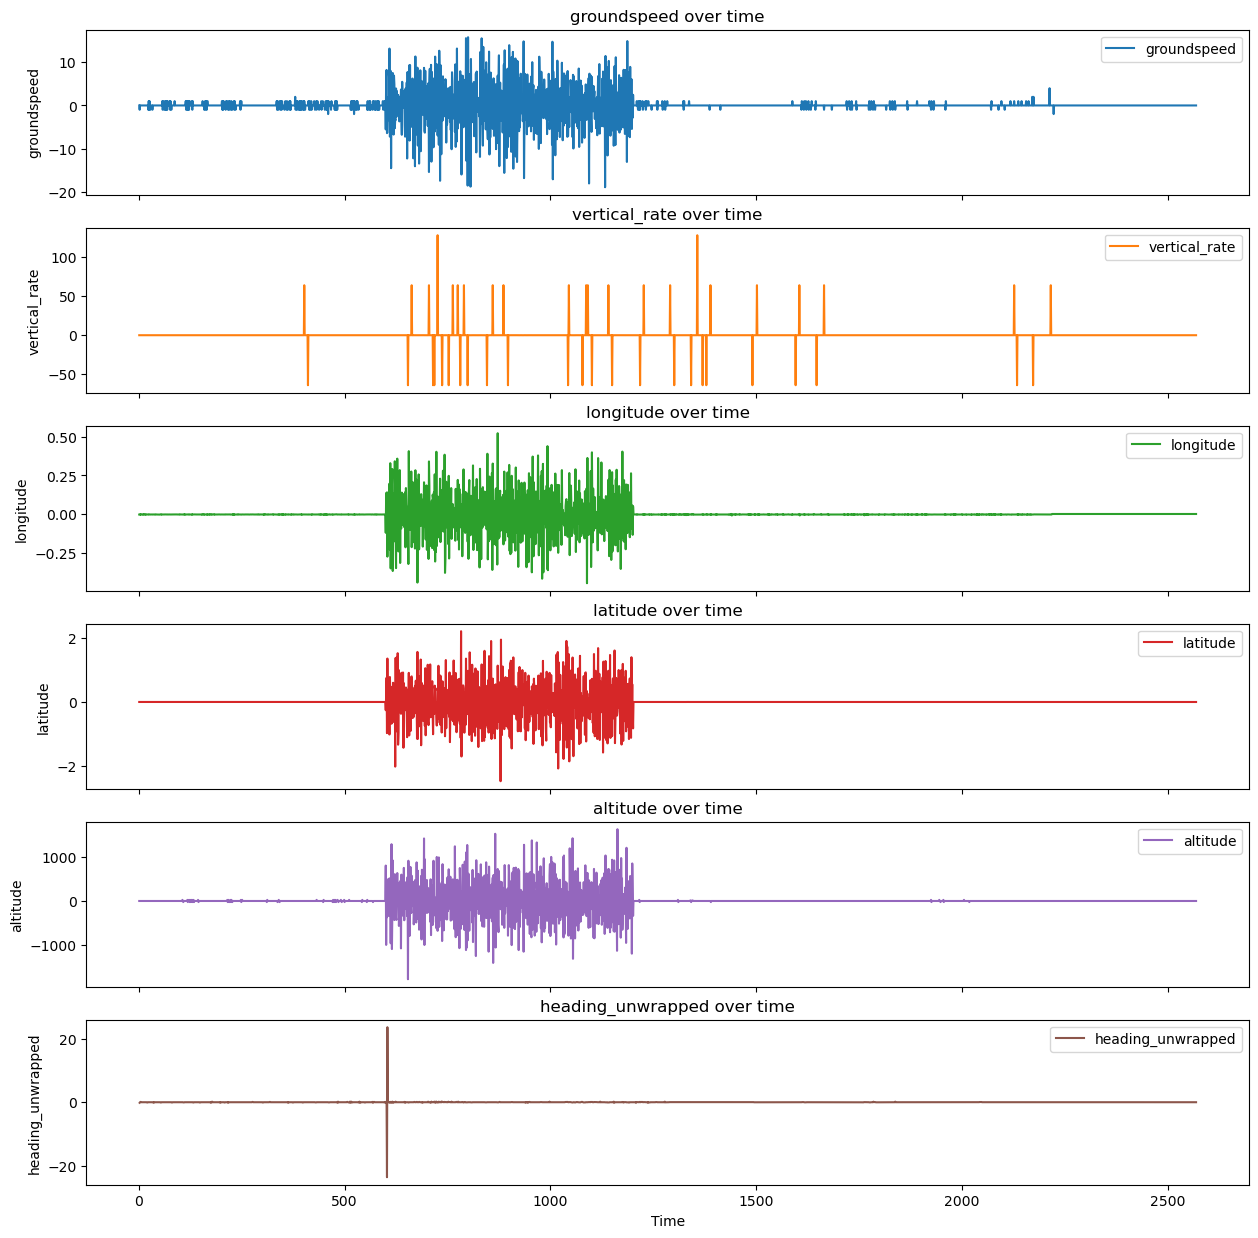

In [13]:
ex = diff_temp_noi_df[STATE_VECTOR_FEATURES].plot(subplots=True, sharex=True, figsize=(15,15))
for e, feature in zip(ex, STATE_VECTOR_FEATURES):
    e.set_title(f'{feature} over time')
    e.set_xlabel('Time')
    e.set_ylabel(feature)
plt.show()

In [5]:
data_dict = {
    "train": [],
    "validation": [],
    "test_noise": [],
    "test_landing": [],
    "test_departing": [],
    "test_manoeuver": [],
}

In [6]:
paths = {
    "train": DATA_TRAIN_DIR,
    "validation": DATA_VALIDATION_DIR,
    "test_noise": DATA_TEST_NOISE_DIR,
    "test_landing": DATA_TEST_LANDING_DIR,
    "test_departing": DATA_TEST_DEPARTING_DIR,
    "test_manoeuver": DATA_TEST_MANOEUVER_DIR
}

In [7]:
for key, path in paths.items():
    files = os.listdir(path)
    
    for file in files:
        file_path = os.path.join(path, file)
        
        # Check if the path is a file
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path)
            
            if key == "train":
                df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=5)
            elif key == "validation":
                df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=8)

            if DIFF_DATA:
                df = diff_data(df, cols=DIFF_FEATURES, lag=K_LAG, order=K_ORDER)
            
            data_dict[key].append(df)

In [8]:
X_windows_list = []
y_windows_list = []

for df in tqdm(data_dict["train"], desc="Processing training data"):
    if df.empty:
        continue  # Skip empty DataFrames
    
    try:
        # Extract windowed data and labels
        windowed_data, windowed_labels = get_windows_data(
            df[FEATURES], 
            [0] * df.shape[0], 
            window_size=WINDOW_SIZE_STANDARD_AUTOENCODER, 
            tsfresh=True
        )
        
        # Append extracted data and labels to lists
        X_windows_list.append(windowed_data)
        y_windows_list.append(windowed_labels)
    
    except Exception as e:
        print(f"Error processing DataFrame: {e}")

Processing training data: 100%|██████████| 26/26 [00:57<00:00,  2.22s/it]


In [9]:
# Assert that the number of feature sets matches the number of label sets
assert len(X_windows_list) == len(y_windows_list)

# Initialize lists and arrays to store the extracted features and labels
extracted_features_list = []
concatenated_labels = np.array([])

# Feature extraction loop with progress bar
for i in tqdm(range(len(X_windows_list)), desc="Extracting features"):
    try:
        # Extract features using tsfresh
        features = extract_features(
            X_windows_list[i], 
            column_id="id", 
            column_sort="time", 
            default_fc_parameters=MinimalFCParameters()
        )
        
        # Impute missing values
        imputed_features = impute(features)
        
        # Append extracted features and labels to respective lists
        extracted_features_list.append(imputed_features)
        concatenated_labels = np.append(concatenated_labels, y_windows_list[i])
    
    except Exception as e:
        # Log errors and continue
        print(f"Error processing index {i}: {e}")
        continue

# Concatenate extracted features into a single DataFrame
if extracted_features_list:  # Ensure the list is not empty
    X_train = pd.concat(extracted_features_list, ignore_index=True)
else:
    X_train = pd.DataFrame()

# Assign labels to y_train
y_train = concatenated_labels

# Verify the final shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Extracting features: 100%|██████████| 24/24 [01:45<00:00,  4.38s/it]

Shape of X_train: (77087, 50)
Shape of y_train: (77087,)


In [10]:
X_train.head()

,altitude__sum_values,altitude__median,altitude__mean,altitude__length,altitude__standard_deviation,altitude__variance,altitude__root_mean_square,altitude__maximum,altitude__absolute_maximum,altitude__minimum,...,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__root_mean_square,y__maximum,y__absolute_maximum,y__minimum
0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11699.400654,195.031458,194.990011,60.0,4.092612,16.749474,195.032956,216.807154,216.807154,176.999066
1,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11719.049257,195.033392,195.317488,60.0,3.360575,11.293462,195.346396,216.807154,216.807154,190.971025
2,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11709.325839,195.033392,195.155431,60.0,3.598403,12.948503,195.188603,216.807154,216.807154,185.268393
3,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11697.123924,195.033392,194.952065,60.0,3.931203,15.454354,194.991698,216.807154,216.807154,182.791829
4,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11698.770600,195.035327,194.979510,60.0,3.937155,15.501187,195.019257,216.807154,216.807154,182.791829


In [11]:
try:
    X_train_n = autoencoder_model_feature_pipeline.fit_transform(X_train)
    print("\nStandardized Training Data:")
    print(X_train_n) 
    
except Exception as e:
    print(f"Error during fit_transform: {e}")
    
# Save the fitted pipeline
joblib.dump(autoencoder_model_feature_pipeline, MODEL_STANDARD_DIR + '/fitted_pipeline.pkl')


Standardized Training Data:
[[ 0.10673933  0.0937922   0.10673933 ...  0.06011089 -0.14805858
   0.39510524]
 [ 0.10673933  0.0937922   0.10673933 ...  0.06011089 -0.14805858
   0.40605512]
 [ 0.10673933  0.0937922   0.10673933 ...  0.06011089 -0.14805858
   0.40158595]
 ...
 [ 0.04236225  0.0937922   0.04236225 ...  0.1220819  -0.10209082
   0.25639037]
 [ 0.04236225  0.0937922   0.04236225 ...  0.1220819  -0.10209082
   0.25639037]
 [ 0.04236225  0.0937922   0.04236225 ...  0.1220819  -0.10209082
   0.25639037]]


['models/standard/fitted_pipeline.pkl']

In [34]:
# Create and compile the quantized autoencoder model
try:

    # create model
    model = get_quantized_autoencoder_model(
        input_dim=X_train_n.shape[1], 
        encoding_dim=STANDARD_AUTOENCODER_ENCODING_DIMENSION
    )

    # prune model
    pruned_model = prune.prune_low_magnitude(model, **pruning_params)

    # compile model
    optimizer = Adam(learning_rate=0.001)
    pruned_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse','mae'])
    
    # Print the model summary to verify the architecture
    pruned_model.summary()
except Exception as e:
    print(f"Error during model creation and compilation: {e}")

2024-07-24 15:20:37.744909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 prune_low_magnitude_q_dense  (None, 10)               1012      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_q_dense  (None, 50)               1052      
 _1 (PruneLowMagnitude)                                          
                                                                 
Total params: 2,064
Trainable params: 1,060
Non-trainable params: 1,004
_________________________________________________________________


Epoch 1/50
482/482 [==============================] - 3s 2ms/step - loss: 0.7840 - mse: 0.7840 - mae: 0.3892 - val_loss: 0.8751 - val_mse: 0.8751 - val_mae: 0.3436
Epoch 2/50
482/482 [==============================] - 1s 2ms/step - loss: 0.5660 - mse: 0.5660 - mae: 0.3241 - val_loss: 0.7728 - val_mse: 0.7728 - val_mae: 0.3100
Epoch 3/50
482/482 [==============================] - 1s 2ms/step - loss: 0.5198 - mse: 0.5198 - mae: 0.3051 - val_loss: 0.7099 - val_mse: 0.7099 - val_mae: 0.2899
Epoch 4/50
482/482 [==============================] - 1s 2ms/step - loss: 0.5036 - mse: 0.5036 - mae: 0.2932 - val_loss: 0.6748 - val_mse: 0.6748 - val_mae: 0.2733
Epoch 5/50
482/482 [==============================] - 1s 2ms/step - loss: 0.5692 - mse: 0.5692 - mae: 0.3186 - val_loss: 0.8002 - val_mse: 0.8002 - val_mae: 0.3030
Epoch 6/50
482/482 [==============================] - 1s 2ms/step - loss: 0.5506 - mse: 0.5506 - mae: 0.3109 - val_loss: 0.7696 - val_mse: 0.7696 - val_mae: 0.2955
Epoch 7/50
482/4

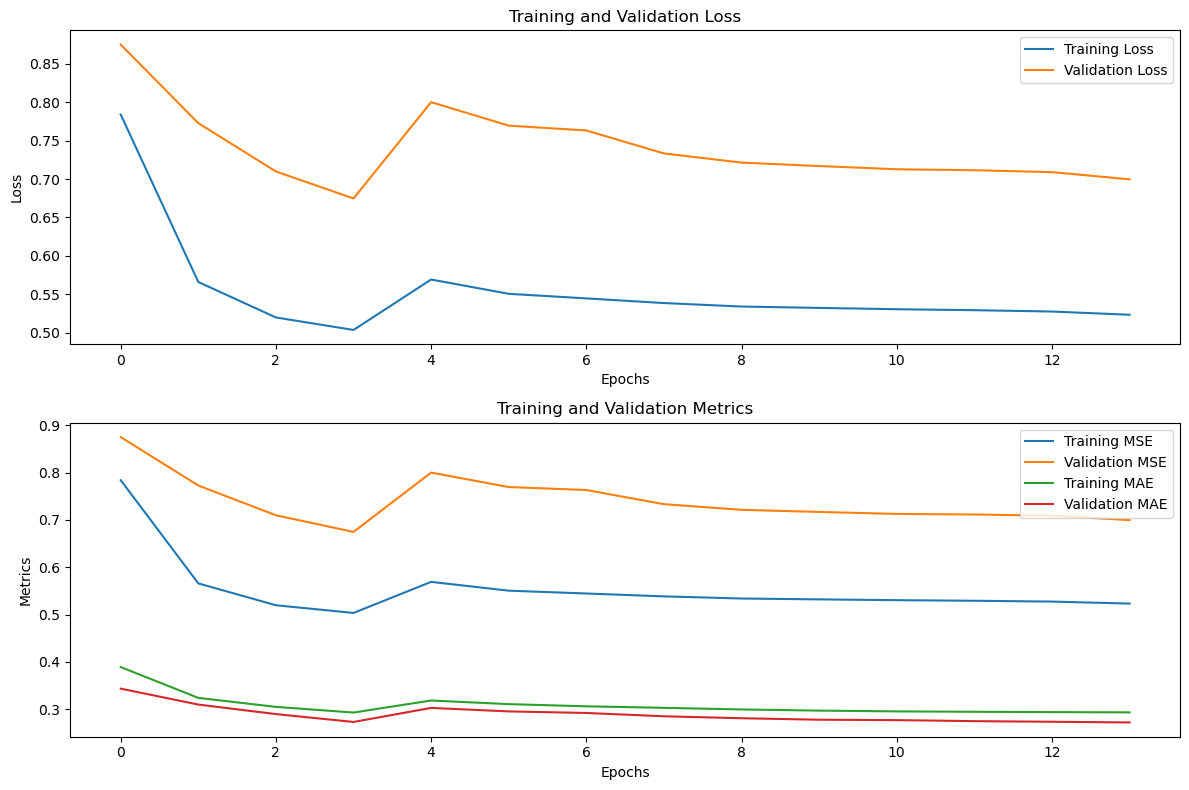

In [39]:
# Train the model
try:
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    pruning_callback = pruning_callbacks.UpdatePruningStep()
    
    history = pruned_model.fit(X_train_n, X_train_n,
                        epochs=50,
                        batch_size=128,
                        shuffle=True,
                        validation_split=0.2,  # Use 20% of the data for validation
                        callbacks=[early_stopping_callback, pruning_callback]).history

    # Save the model but with the pruning 'stripped' to use the regular layer types
    stripped_model = strip_pruning(pruned_model)

    print("Model training completed successfully.")
except Exception as e:
    print(f"Error during model training: {e}")

plot_training_history(history)

In [40]:
stripped_model.save(MODEL_STANDARD_DIR)

INFO:tensorflow:Assets written to: models/standard/assets


INFO:tensorflow:Assets written to: models/standard/assets
